Читаем feature store: data/processed/features_offline_v11.parquet
Всего строк: 13113
Колонок: 211
Пример колонок: ['transdatetime', 'cst_dim_id', 'transdate', 'amount', 'docno', 'direction', 'target', 'row_id', 'sess_monthly_os_changes', 'sess_monthly_phone_model_changes', 'sess_logins_7d', 'sess_logins_30d', 'sess_login_freq_7d', 'sess_login_freq_30d', 'sess_freq_change_7d_vs_mean', 'sess_logins_7d_30d_ratio', 'sess_avg_login_interval_30d', 'sess_std_login_interval_30d', 'sess_var_login_interval_30d', 'sess_ewm_login_interval_7d'] ...

Распределение target:
target
0    12948
1      165
Name: count, dtype: int64
Доля фрода: 0.012582932967284374

Проверяем наличие OOF-колонок:
  ✅ Fast Gate: колонка risk_fast_oof_v11 найдена.
  ✅ AE Brain: колонка risk_ae_oof_v11 найдена.
  ✅ Graph Brain: колонка graph_brain_oof_v11 найдена.
  ✅ Sequence Brain: колонка risk_seq_oof_v11 найдена.
  ✅ Session Brain: колонка risk_sess_oof_v11 найдена.
  ✅ Meta Brain vProd: колонка risk_meta_oof_vprod найден

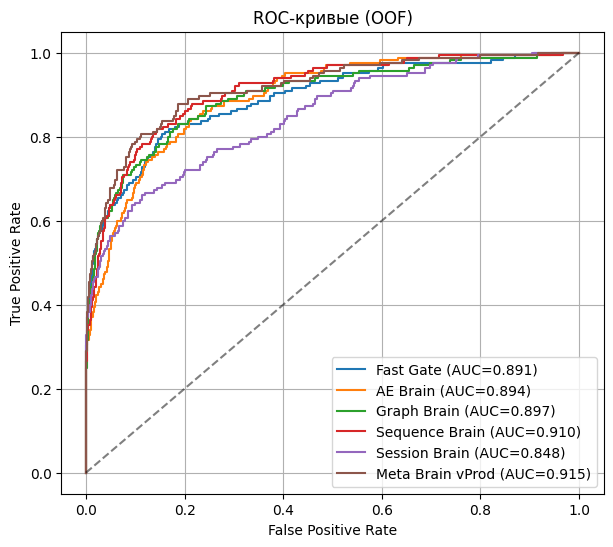

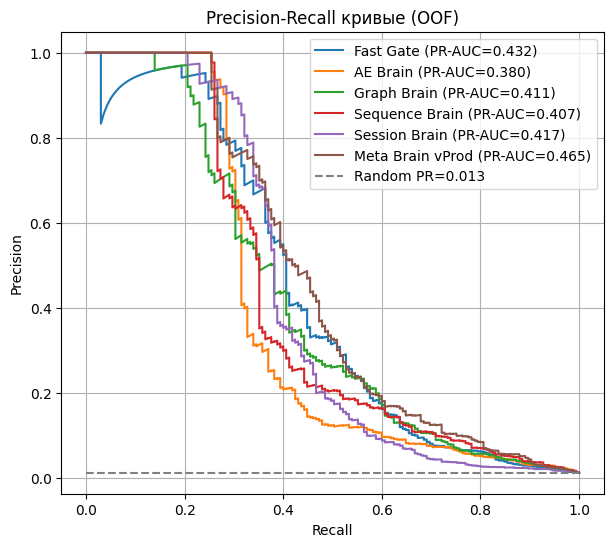


=== Бизнес-метрики по стратегиям (OOF) ===
           model    strategy  threshold  precision    recall        f1   tp  \
0  Session Brain  Aggressive   0.008838   0.022589  0.903030  0.044076  149   
1  Session Brain    Balanced   0.754308   0.708861  0.339394  0.459016   56   
2  Session Brain    Friendly   0.999955   1.000000  0.006061  0.012048    1   

     fp   fn     tn  alerts  alerts_frac  
0  6447   16   6501    6596     0.503012  
1    23  109  12925      79     0.006025  
2     0  164  12948       1     0.000076  
Fast Gate v11: feature importance сохранены в data/processed/fast_gate_feature_importance_v11.parquet
                       feature  importance
33                  degree_cst    7.305514
0                       amount    6.026513
11                  log_amount    5.629148
9                     hour_sin    3.990985
15        user_mean_amount_30d    3.425632
17        user_mean_amount_90d    3.379311
32                z_amount_30d    3.314904
50  sess_ewm_login_in

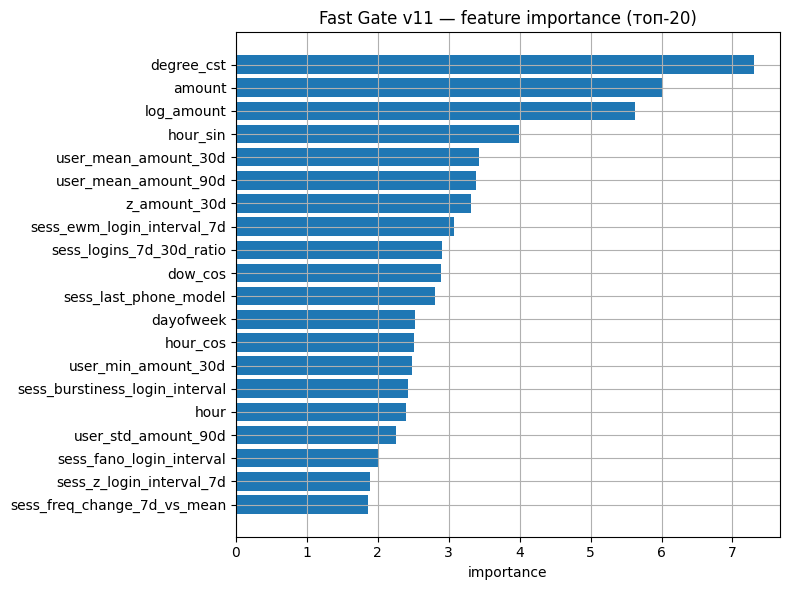

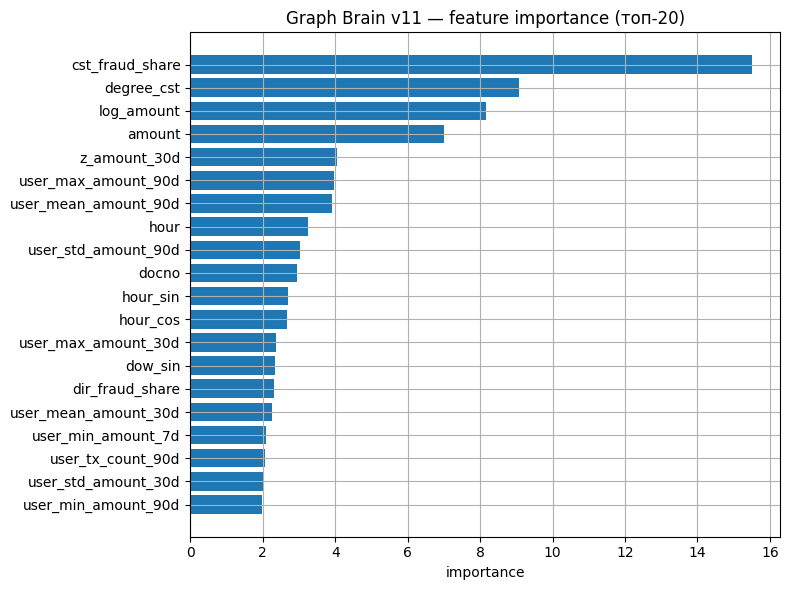

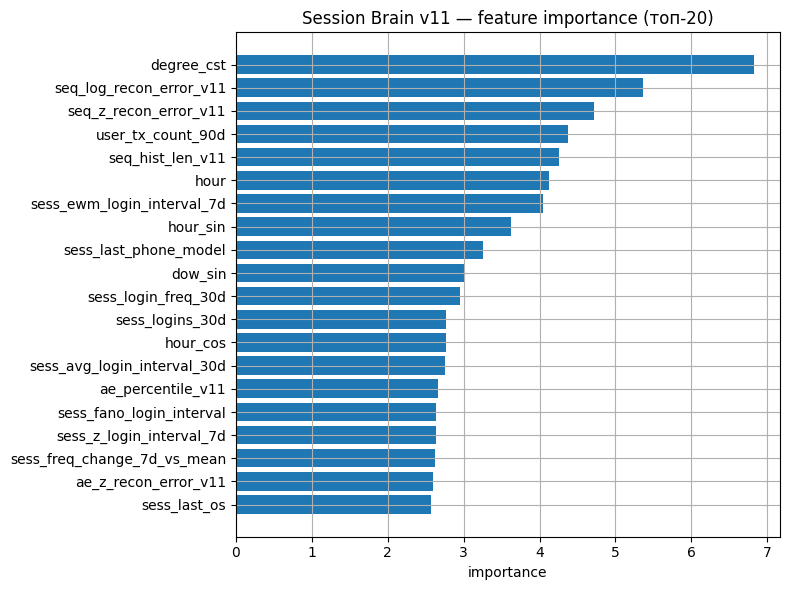

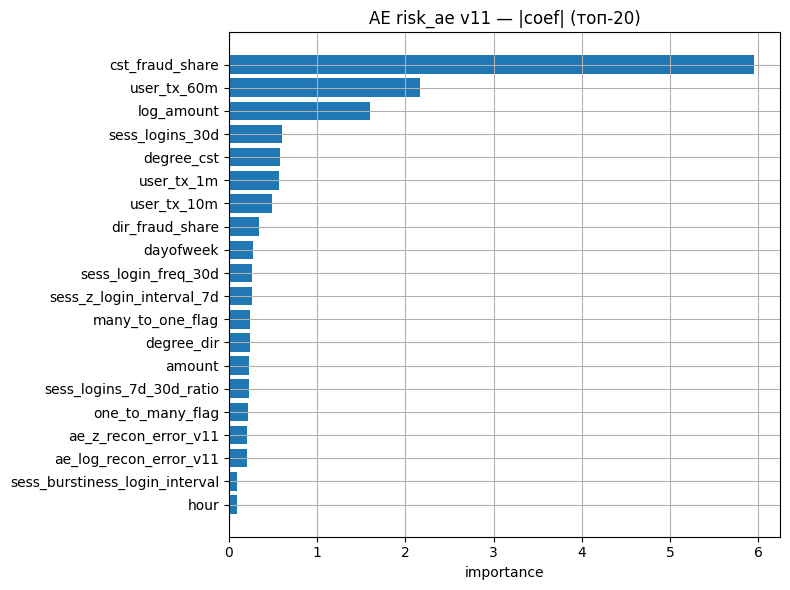

⚠️ Sequence risk_seq v11 — |coef| (топ-20): нет данных для графика.


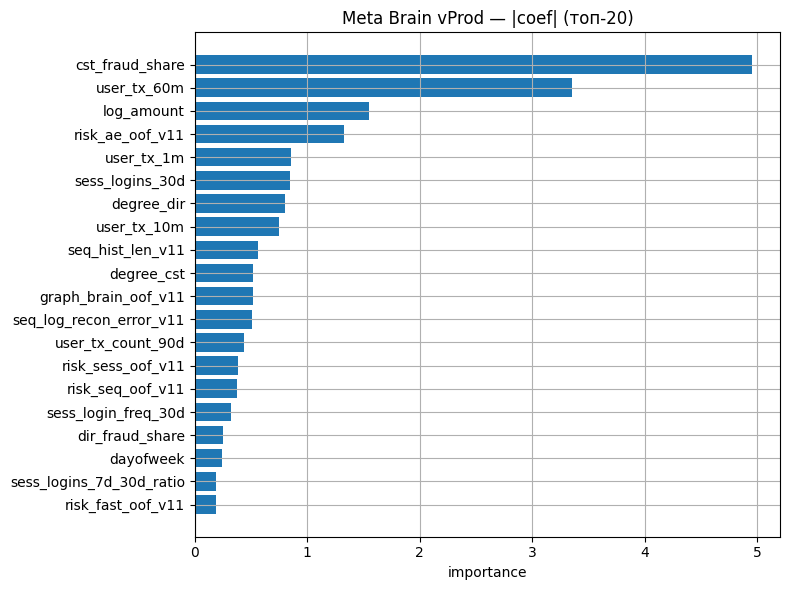


✅ Готово: все метрики и feature importance посчитаны и сохранены в папки:
 - reports/
 - data/processed/


In [ ]:

!pip install catboost

import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
)

from catboost import CatBoostClassifier
import joblib

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = True

PROJECT_ROOT = Path(".")
DATA_ROOT = PROJECT_ROOT / "data"
PROC_PATH = DATA_ROOT / "processed"
CONFIG_PATH = PROJECT_ROOT / "config"
MODELS_PATH = PROJECT_ROOT / "models"
REPORTS_PATH = PROJECT_ROOT / "reports"
REPORTS_PATH.mkdir(parents=True, exist_ok=True)

FEATURES_PARQUET = PROC_PATH / "features_offline_v11.parquet"

print("Читаем feature store:", FEATURES_PARQUET)
df = pd.read_parquet(FEATURES_PARQUET)

print(f"Всего строк: {len(df)}")
print(f"Колонок: {df.shape[1]}")
print("Пример колонок:", df.columns[:20].tolist(), "...")
print("\nРаспределение target:")
print(df["target"].value_counts())
print("Доля фрода:", df["target"].mean())

y = df["target"].values.astype(int)

MODEL_SCORES = {
    "Fast Gate": "risk_fast_oof_v11",
    "AE Brain": "risk_ae_oof_v11",
    "Graph Brain": "graph_brain_oof_v11",
    "Sequence Brain": "risk_seq_oof_v11",
    "Session Brain": "risk_sess_oof_v11",
    "Meta Brain vProd": "risk_meta_oof_vprod",
}

print("\nПроверяем наличие OOF-колонок:")
for name, col in MODEL_SCORES.items():
    if col not in df.columns:
        print(f"  ⚠️ {name}: колонка {col} НЕ найдена, модель будет исключена из сравнения.")
    else:
        print(f"  ✅ {name}: колонка {col} найдена.")

MODEL_SCORES = {k: v for k, v in MODEL_SCORES.items() if v in df.columns}

def compute_base_metrics(y_true, scores):
    """ROC-AUC, PR-AUC и лучший F1 по всем порогам."""
    roc_auc = roc_auc_score(y_true, scores)
    pr_auc = average_precision_score(y_true, scores)

    prec, rec, thr = precision_recall_curve(y_true, scores)
    f1 = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)

    best_idx = int(np.nanargmax(f1))
    best = {
        "best_threshold": float(thr[best_idx]),
        "best_precision": float(prec[best_idx]),
        "best_recall": float(rec[best_idx]),
        "best_f1": float(f1[best_idx]),
    }

    return {
        "roc_auc": float(roc_auc),
        "pr_auc": float(pr_auc),
        **best,
    }


def metrics_at_threshold(y_true, scores, threshold):
    """Бизнес-метрики при конкретном пороге."""
    pred = (scores >= threshold).astype(int)

    tp = int(((pred == 1) & (y_true == 1)).sum())
    fp = int(((pred == 1) & (y_true == 0)).sum())
    fn = int(((pred == 0) & (y_true == 1)).sum())
    tn = int(((pred == 0) & (y_true == 0)).sum())

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (
        2 * precision * recall / (precision + recall + 1e-12)
        if (precision + recall) > 0
        else 0.0
    )

    alerts = tp + fp
    alerts_frac = alerts / len(y_true)

    return {
        "threshold": float(threshold),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn,
        "alerts": alerts,
        "alerts_frac": alerts_frac,
    }


def plot_roc_curves(y_true, model_scores, out_path=None):
    plt.figure(figsize=(7, 6))
    for name, col in model_scores.items():
        scores = df[col].values
        fpr, tpr, _ = roc_curve(y_true, scores)
        auc_ = roc_auc_score(y_true, scores)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_:.3f})")

    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривые (OOF)")
    plt.legend()
    if out_path:
        plt.savefig(out_path, bbox_inches="tight", dpi=200)
    plt.show()


def plot_pr_curves(y_true, model_scores, out_path=None):
    plt.figure(figsize=(7, 6))
    baseline = y_true.mean()
    for name, col in model_scores.items():
        scores = df[col].values
        prec, rec, _ = precision_recall_curve(y_true, scores)
        pr_auc = average_precision_score(y_true, scores)
        plt.plot(rec, prec, label=f"{name} (PR-AUC={pr_auc:.3f})")

    plt.hlines(
        baseline, 0, 1, linestyles="dashed", colors="gray", label=f"Random PR={baseline:.3f}"
    )
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall кривые (OOF)")
    plt.legend()
    if out_path:
        plt.savefig(out_path, bbox_inches="tight", dpi=200)
    plt.show()


rows = []
for name, col in MODEL_SCORES.items():
    m = compute_base_metrics(y, df[col].values)
    row = {"model": name, "score_col": col, **m}
    rows.append(row)

metrics_df = pd.DataFrame(rows).sort_values("pr_auc", ascending=False)
print("\n=== Сводная таблица базовых метрик (OOF) ===")
print(metrics_df)

metrics_df.to_csv(REPORTS_PATH / "metrics_oof_summary_v11_meta_vprod.csv", index=False)

plot_roc_curves(
    y, MODEL_SCORES, out_path=REPORTS_PATH / "roc_curves_oof_v11_meta_vprod.png"
)
plot_pr_curves(
    y, MODEL_SCORES, out_path=REPORTS_PATH / "pr_curves_oof_v11_meta_vprod.png"
)

THRESHOLD_CONFIGS = {
    "Fast Gate": CONFIG_PATH / "strategy_thresholds_v11.json",
    "AE Brain": CONFIG_PATH / "autoencoder_thresholds_v11.json",
    "Graph Brain": CONFIG_PATH / "graph_brain_thresholds_v11.json",
    "Sequence Brain": CONFIG_PATH / "sequence_thresholds_v11.json",
    "Session Brain": CONFIG_PATH / "session_thresholds_v11.json",
    "Meta Brain vProd": CONFIG_PATH / "meta_thresholds_vprod.json",
}

rows = []
for name, col in MODEL_SCORES.items():
    cfg_path = THRESHOLD_CONFIGS.get(name)
    if not cfg_path or not cfg_path.exists():
        print(f"\n⚠️ Для {name} не найден config с порогами ({cfg_path}), пропускаем.")
        continue

    with open(cfg_path, "r", encoding="utf-8") as f:
        cfg = json.load(f)

    scores = df[col].values

    for strategy in ["Aggressive", "Balanced", "Friendly"]:
        if strategy not in cfg:
            continue
        thr = cfg[strategy]["threshold"]
        met = metrics_at_threshold(y, scores, thr)
        met_row = {"model": name, "strategy": strategy, **met}
        rows.append(met_row)

biz_df = pd.DataFrame(rows)
if not biz_df.empty:
    biz_df = biz_df.sort_values(["model", "strategy"])
    print("\n=== Бизнес-метрики по стратегиям (OOF) ===")
    print(biz_df)
    biz_df.to_csv(
        REPORTS_PATH / "business_metrics_by_strategy_v11_meta_vprod.csv", index=False
    )
else:
    print("\n⚠️ Не удалось собрать бизнес-метрики по стратегиям (нет JSON-порогов).")


def compute_catboost_fi(model_path: Path, title: str, out_parquet: Path):
    """Считать feature importance для CatBoost-модели."""
    if not model_path.exists():
        print(f"⚠️ {title}: модель {model_path} не найдена, пропускаем.")
        return None

    model = CatBoostClassifier()
    model.load_model(str(model_path))

    importances = model.get_feature_importance(type="FeatureImportance")
    feature_names = model.feature_names_
    if not feature_names or len(feature_names) != len(importances):
        # fallback — просто f_0, f_1, ...
        feature_names = [f"f_{i}" for i in range(len(importances))]

    fi_df = pd.DataFrame(
        {"feature": feature_names, "importance": importances}
    ).sort_values("importance", ascending=False)

    out_parquet.parent.mkdir(parents=True, exist_ok=True)
    fi_df.to_parquet(out_parquet, index=False)
    print(f"{title}: feature importance сохранены в {out_parquet}")
    print(fi_df.head(10))
    return fi_df


def compute_logreg_fi(
    model_path: Path, features_json: Path, title: str, out_parquet: Path
):
    """Считать feature importance как |coef| из LogisticRegression (внутри pipeline)."""
    if not model_path.exists():
        print(f"⚠️ {title}: модель {model_path} не найдена, пропускаем.")
        return None
    if not features_json.exists():
        print(f"⚠️ {title}: файл с фичами {features_json} не найден, пропускаем.")
        return None

    model = joblib.load(model_path)

    
    clf = None
    if hasattr(model, "named_steps"):
        # Pipeline
        for step_name, step in model.named_steps.items():
            if hasattr(step, "coef_"):
                clf = step
        if clf is None:
            print(f"⚠️ {title}: в pipeline нет шага с coef_, пропускаем.")
            return None
    else:
        clf = model
        if not hasattr(clf, "coef_"):
            print(f"⚠️ {title}: модель не имеет coef_, пропускаем.")
            return None

    with open(features_json, "r", encoding="utf-8") as f:
        feats = json.load(f)
    if isinstance(feats, dict):
        
        for key in ["features", "meta_features", "feature_names"]:
            if key in feats:
                feats = feats[key]
                break

    coefs = clf.coef_.reshape(-1)
    if len(feats) != len(coefs):
        print(
            f"⚠️ {title}: len(features)={len(feats)} != len(coef_)={len(coefs)}, "
            f"обрежем до min."
        )
        n = min(len(feats), len(coefs))
        feats = feats[:n]
        coefs = coefs[:n]

    fi_df = pd.DataFrame(
        {"feature": feats, "importance": np.abs(coefs), "coef": coefs}
    ).sort_values("importance", ascending=False)

    out_parquet.parent.mkdir(parents=True, exist_ok=True)
    fi_df.to_parquet(out_parquet, index=False)
    print(f"{title}: feature importance сохранены в {out_parquet}")
    print(fi_df.head(10))
    return fi_df


fi_fast = compute_catboost_fi(
    MODELS_PATH / "catboost_fast_gate_v11.cbm",
    title="Fast Gate v11",
    out_parquet=PROC_PATH / "fast_gate_feature_importance_v11.parquet",
)

fi_graph = compute_catboost_fi(
    MODELS_PATH / "graph_brain_v11.cbm",
    title="Graph Brain v11",
    out_parquet=PROC_PATH / "graph_brain_feature_importance_v11.parquet",
)

fi_session = compute_catboost_fi(
    MODELS_PATH / "session_brain_v11.cbm",
    title="Session Brain v11",
    out_parquet=PROC_PATH / "session_feature_importance_v11.parquet",
)

fi_ae_meta = compute_logreg_fi(
    MODELS_PATH / "tx_autoencoder_meta_v11.pkl",
    CONFIG_PATH / "autoencoder_meta_features_v11.json",
    title="AE risk_ae v11",
    out_parquet=PROC_PATH / "autoencoder_meta_feature_importance_v11.parquet",
)

fi_seq_meta = compute_logreg_fi(
    MODELS_PATH / "seq_meta_v11.pkl",
    CONFIG_PATH / "sequence_meta_features_v11.json",
    title="Sequence risk_seq v11",
    out_parquet=PROC_PATH / "sequence_meta_feature_importance_v11.parquet",
)

fi_meta_vprod = compute_logreg_fi(
    MODELS_PATH / "risk_meta_vprod.pkl",
    CONFIG_PATH / "meta_features_vprod.json",
    title="Meta Brain vProd",
    out_parquet=PROC_PATH / "meta_feature_importance_vprod.parquet",
)


def plot_top_features(fi_df: pd.DataFrame, title: str, value_col: str, top_n: int, out_name: str):
    if fi_df is None or fi_df.empty:
        print(f"⚠️ {title}: нет данных для графика.")
        return

    df_top = fi_df.sort_values(value_col, ascending=False).head(top_n)
    df_top = df_top.iloc[::-1]  # чтобы самые важные были сверху

    plt.figure(figsize=(8, max(4, top_n * 0.3)))
    plt.barh(df_top["feature"], df_top[value_col])
    plt.title(title)
    plt.xlabel(value_col)
    plt.tight_layout()
    plt.savefig(REPORTS_PATH / out_name, bbox_inches="tight", dpi=200)
    plt.show()



plot_top_features(
    fi_fast,
    title="Fast Gate v11 — feature importance (топ-20)",
    value_col="importance",
    top_n=20,
    out_name="fi_fast_gate_v11.png",
)

plot_top_features(
    fi_graph,
    title="Graph Brain v11 — feature importance (топ-20)",
    value_col="importance",
    top_n=20,
    out_name="fi_graph_brain_v11.png",
)

plot_top_features(
    fi_session,
    title="Session Brain v11 — feature importance (топ-20)",
    value_col="importance",
    top_n=20,
    out_name="fi_session_brain_v11.png",
)


plot_top_features(
    fi_ae_meta,
    title="AE risk_ae v11 — |coef| (топ-20)",
    value_col="importance",
    top_n=20,
    out_name="fi_ae_meta_v11.png",
)

plot_top_features(
    fi_seq_meta,
    title="Sequence risk_seq v11 — |coef| (топ-20)",
    value_col="importance",
    top_n=20,
    out_name="fi_seq_meta_v11.png",
)

plot_top_features(
    fi_meta_vprod,
    title="Meta Brain vProd — |coef| (топ-20)",
    value_col="importance",
    top_n=20,
    out_name="fi_meta_vprod.png",
)

print("\nГотово: все метрики и feature importance посчитаны и сохранены в папки:")
print(" - reports/")
print(" - data/processed/")


In [ ]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# -----------------------
# Пути
# -----------------------
DATA_ROOT = Path("data")
PROC_PATH = DATA_ROOT / "processed"
CONFIG_PATH = Path("config")
REPORTS_PATH = Path("reports")
REPORTS_PATH.mkdir(parents=True, exist_ok=True)

FEATURE_STORE = PROC_PATH / "features_offline_v11.parquet"

# -----------------------
# Загрузка feature store
# -----------------------
print(f"Читаем feature store: {FEATURE_STORE}")
df = pd.read_parquet(FEATURE_STORE)

y = df["target"].values.astype(int)
n = len(y)
pos_frac = y.mean()
print(f"Всего строк: {n}, fraud_frac={pos_frac:.4f}\n")

# -----------------------
# Хелпер: бизнес-метрики
# -----------------------
def compute_business_metrics(y_true, y_score, thr, model_name, strategy_name):
    y_pred = (y_score >= thr).astype(int)

    tp = int(((y_true == 1) & (y_pred == 1)).sum())
    fp = int(((y_true == 0) & (y_pred == 1)).sum())
    fn = int(((y_true == 1) & (y_pred == 0)).sum())
    tn = int(((y_true == 0) & (y_pred == 0)).sum())
    alerts = tp + fp
    alerts_frac = alerts / len(y_true)

    # аккуратно считаем p/r/f1
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )

    return {
        "model": model_name,
        "strategy": strategy_name,
        "threshold": float(thr),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn,
        "alerts": alerts,
        "alerts_frac": alerts_frac,
    }

# -----------------------
# Описание всех мозгов
# -----------------------
models_cfg = [
    {
        "name": "Fast Gate v11",
        "score_col": "risk_fast_oof_v11",
        "thr_json": CONFIG_PATH / "strategy_thresholds_v11.json",
    },
    {
        "name": "AE Brain v11",
        "score_col": "risk_ae_oof_v11",
        "thr_json": CONFIG_PATH / "autoencoder_thresholds_v11.json",
    },
    {
        "name": "Graph Brain v11",
        "score_col": "graph_brain_oof_v11",
        "thr_json": CONFIG_PATH / "graph_brain_thresholds_v11.json",
    },
    {
        "name": "Sequence Brain v11",
        "score_col": "risk_seq_oof_v11",
        "thr_json": CONFIG_PATH / "sequence_thresholds_v11.json",
    },
    {
        "name": "Session Brain v11",
        "score_col": "risk_sess_oof_v11",
        "thr_json": CONFIG_PATH / "session_thresholds_v11.json",
    },
    {
        "name": "Meta Brain vProd",
        "score_col": "risk_meta_oof_vprod",
        "thr_json": CONFIG_PATH / "meta_thresholds_vprod.json",
    },
]

# -----------------------
# Расчёт по всем стратегиям и моделям
# -----------------------
rows = []
strategies_order = ["Aggressive", "Balanced", "Friendly"]

for cfg in models_cfg:
    name = cfg["name"]
    score_col = cfg["score_col"]
    thr_path = cfg["thr_json"]

    if score_col not in df.columns:
        print(f"⚠️ Колонка {score_col} не найдена, пропускаем {name}")
        continue

    with open(thr_path, "r", encoding="utf-8") as f:
        thr_dict = json.load(f)

    # на всякий случай нормализуем ключи (Aggressive/Balanced/Friendly)
    norm_thr = {}
    for k, v in thr_dict.items():
        key = k.capitalize()
        norm_thr[key] = v

    print(f"\n=== {name} ===")
    print(f"  score_col: {score_col}")
    print(f"  thresholds: {[k for k in norm_thr.keys()]}")

    y_score = df[score_col].values.astype(float)

    for strat in strategies_order:
        if strat not in norm_thr:
            continue
        thr = norm_thr[strat]["threshold"]
        row = compute_business_metrics(
            y_true=y,
            y_score=y_score,
            thr=thr,
            model_name=name,
            strategy_name=strat,
        )
        rows.append(row)

# -----------------------
# Итоговая таблица
# -----------------------
metrics_df = pd.DataFrame(rows)

# сортируем модели и стратегии красиво
metrics_df["strategy"] = pd.Categorical(
    metrics_df["strategy"], categories=strategies_order, ordered=True
)
metrics_df = metrics_df.sort_values(["model", "strategy"]).reset_index(drop=True)

pd.set_option("display.max_rows", None)
pd.set_option("display.width", 200)

print("\n=== Бизнес-метрики по стратегиям (OOF) для всех мозгов ===")
print(metrics_df)

out_path = REPORTS_PATH / "strategy_business_metrics_v11.csv"
metrics_df.to_csv(out_path, index=False)
print(f"\n✅ Таблица бизнес-метрик сохранена в {out_path}")
print(f"Random baseline PR (fraud share): {pos_frac:.4f}")


Читаем feature store: data/processed/features_offline_v11.parquet
Всего строк: 13113, fraud_frac=0.0126


=== Fast Gate v11 ===
  score_col: risk_fast_oof_v11
  thresholds: ['Aggressive', 'Balanced', 'Friendly']

=== AE Brain v11 ===
  score_col: risk_ae_oof_v11
  thresholds: ['Anomaly_score', 'Risk_ae', 'Oof_metrics', 'Ae_metrics']

=== Graph Brain v11 ===
  score_col: graph_brain_oof_v11
  thresholds: ['Version', 'Thresholds', 'Oof_metrics']

=== Sequence Brain v11 ===
  score_col: risk_seq_oof_v11
  thresholds: ['Aggressive', 'Balanced', 'Friendly']

=== Session Brain v11 ===
  score_col: risk_sess_oof_v11
  thresholds: ['Aggressive', 'Balanced', 'Friendly']

=== Meta Brain vProd ===
  score_col: risk_meta_oof_vprod
  thresholds: ['Aggressive', 'Balanced', 'Friendly']

=== Бизнес-метрики по стратегиям (OOF) для всех мозгов ===
                 model    strategy  threshold  precision    recall        f1   tp     fp   fn     tn  alerts  alerts_frac
0        Fast Gate v11  Aggressive  